## Predicting Blight Compliance

Every year, Detroit issues millions of dollars in fines to residents that fail to maintain their property (called blight violations), and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a violator might fail to comply with a blight ticket. This notebook attempts to accurately model whether a given blight ticket will be paid on time. Armed with such information, the city is better equipped to decide which violators its limited resources are best spent pursuing.

The primary file used for modelling is train.csv. Each row in train.csv corresponds to a single blight ticket and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing date, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible.

All tickets where the violators were found not responsible are not considered during evaluation. They could however be used as an additional source of data for visualization or for unsupervised and semi-supervised approaches. However, they are not included in the test set.

The second key file is Parcel_Points_Ownership.csv. Full variable descriptions are not available for this dataset. Generally, it contains information about properties such as their owners, their tax status, their size, the year in which they were built etc. The nature of most of the variables can be inferred from their name. This data is merged with the data in train.csv to create more predictor variables.

## Blight Variable Descriptions (train.csv)

The following variables are found in train.csv. Full descriptions of the variables in parcel points are not available but most of the labels are intuitive.

ticket_id - unique identifier for tickets

agency_name - Agency that issued the ticket

inspector_name - Name of inspector that issued the ticket

violator_name - Name of the person/organization that the ticket was issued to

violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred

mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator

ticket_issued_date - Date and time the ticket was issued

hearing_date - Date and time the violator's hearing was scheduled

violation_code, violation_description - Type of violation

disposition - Judgment and judgement type

fine_amount - Violation fine amount, excluding fees

admin_fee - $20 fee assigned to responsible judgments

state_fee - $10 fee assigned to responsible judgments

late_fee - 10% fee assigned to responsible judgments

discount_amount - discount applied, if any

clean_up_cost - DPW clean-up or graffiti removal cost

judgment_amount - Sum of all fines and fees

grafitti_status - Flag for graffiti violations

The following variables are contained within the dataset but are not available at testing stage.

payment_amount - Amount paid, if any

payment_date - Date payment was made, if it was received

payment_status - Current payment status as of Feb 1 2017

balance_due - Fines and fees still owed

collection_status - Flag for payments in collections

compliance [target variable for prediction] Null = Not responsible 0 = Responsible, non-compliant 1 = Responsible, compliant

compliance_detail - More information on why each ticket was marked compliant or non-compliant

## Performance Metrics

Since this is a binary problem with imbalanced classes, accuracy is an inappropriate measure of performance: a high accuracy score can be achieved by simply predicting the majority class in all cases. This problem could in theory be rectified by artificially balancing the classes using undersampling and oversampling techniques, in which case accuracy would be an appropriate measure. When this was tried, however, performance on a number of metrics such as precision, f-score and auc did not improve significantly. This is not all that surprising given how difficult it is to separate the classes for this problem (shown in the PCA visualisations for this notebook) even after engineering new features. The problem is that because the classes overlap so strongly, oversampling simply generates new examples that overlap. Undersampling on the other hand removes information and does not help with separability.

When initially building the model, the relative importance of false positives and false negatives was treated agnostically since both could be important. Which is more important depends on factors such as the resources available to the Detroit government (explained below). Since we do not know this information, we tuned the model by optimising for the area under the receiver operating characteristic curve rather than optimising for predision or recall. While in practice a weighted f score might be better once we know which of false negatives and false positives are more important, a different choice is unlikely to affect the optimal parameters significantly given that the model cannot optimise for any of these measures directly. Hence for practicality
AUC is used as a first approximation decision thresholds are altered to see how other metrics could be improved once the model is built.

Ultimately, the optimal decision thresholds (probabilities chosen for classification) will depend on the relative cost of false positives and false negatives in practice. Given limited resources, it might be the case that a false negative (compliance is the positive class) is particularly costly: resources will be wasted in chasing a violator that will pay anyway when these resources could otherwise be used in chasing someone who wouldn't pay. A false positive, on the other hand, might not be particularly costly if the state does not have enough resources to chase all non compliant violators: failing to chase a violator does not represent a missed opportunity if there are not enough resources to pursue all violators.

This project shows how the decision threshold can be altered to achieve different results, depending on whether false positives or false negatives are more costly. The final section shows that the model might be more useful in practice that simplistic performance metrics imply. This is because if state resources are limited and the state rationally uses the predicted probabilities from the model to pursue violators with the highest predited probabilities of non-compliance first, results will be far better than if they could pursue all predicted non complies. For example, it is shown that for the highest 1000 predicted to be non compliant, only 14 were actually compliant. This means that if only a fraction of the violators can be pursued in any case, very little wastage would occur.




## Data Preprocessing

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.preprocessing import Imputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
import pickle
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC, LinearSVR
from keras.preprocessing.text import Tokenizer
from numpy import array
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Imputer
# from imblearn.combine import SMOTETomek
# from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

In [14]:
# Create an inline choose files button. After selecting your file(s), uploaded will be a dictionary of keys (the file names) and values (the encoded file objects).

from google.colab import files
uploaded = files.upload()

Saving addresses.csv to addresses (8).csv
Saving latlons.csv to latlons (2).csv
Saving names_comparison.csv to names_comparison (2).csv
Saving Parcel_Points_Ownership.csv to Parcel_Points_Ownership (2).csv
Saving train.csv to train (1).csv


## Preprocessing

In [15]:
import io
blight = pd.read_csv('train.csv', engine = 'python')
parcel_points = pd.read_csv('Parcel_Points_Ownership.csv')
addresses = pd.read_csv(io.StringIO(uploaded['addresses.csv'].decode('utf-8')))
# Data on the latitudes and longitudes at different addresses.
latlons = pd.read_csv('latlons.csv')
# This data was created from the violator names feature of the blight dataframe above in another file. It converts the names into entity types using a model based on an academic paper
# that concatenates LSTM neural networks. The aim is to generate features from names. The method used to generate this file can be find on this github in the entity identifier project.
names_comparison = pd.read_csv('names_comparison.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
# Entity features from the violator names. The method used to generate these features can be found in the entity identifier project on this github.
blight['label'] = names_comparison['label']

In [0]:
# Merge latlons with addresses. This will create a composite dataframe which we can perform an inner merge on addresses
# with blight, thus allowing us to use location data (latitudes and longitudes) to predict blight.
addresses_and_latlons = addresses.merge(latlons,left_on = 'address', right_on = 'address', how = 'inner')
# Merge address and location information into training and test set dataframes.
blight = blight.merge(addresses_and_latlons, left_on = 'ticket_id', right_on = 'ticket_id', how = 'inner')

# Convert the ticket issued date and permit issued columns of the blight and building permit dataframes to datetime objects
# so we can sort the resulting dataframes in ascending order of date.
blight['ticket_issued_date'] = pd.to_datetime(blight['ticket_issued_date'])
blight.sort_values('ticket_issued_date',inplace = True)

# Reformat the address in the blight dataframe to match that of the parcel points dataframe so that merging is possible.
blight['address_formatted'] = blight['violation_street_number'].astype(int).astype(str) + ' ' + blight['violation_street_name']
blight = blight.merge(parcel_points, left_on = 'address_formatted', right_on = 'Address', how = 'inner')

## Aside on Generating Features from Violator Names

One of the variables in the dataset is violator name. In some cases, this is the name of a business. In other cases, it is the name of an individual property owner. Unfortunately, there is no indication in the data as to the type of entity each name refers to, even though such information is likely informative about the probability of complying with a fine for blight violation. For example, it might be the case that a limited liability company is more likely to comply than a non-profit, or a female more likely to comply than a male. For this reason, attempts were made to convert these names into entity types.

The first attempt involved using NLTKs entity namer. This approach did not improve predictive performance, most likely because NLTKs functionality creates chunks from sentences and infers the entity types of particular words in the sentence using the context created by the words in the sentence. Given that the sentences in question were simply names and businesses, the model did not have a great deal to go on. Not unexpectedly, the attempt at named entity recognition returned poor results. Simple comparison of the violator names column with the predicted entity showed that the results were only marginally better than random guesses, and far worse than human performance. The problem was exacerbated by the fact that for some entity names, multiple entities were recognised, which led to the adoption of a rule of thumb approach of selecting the first entity recognised as the feature. This is obviously a weak and arbitrary assumption given that each name is only supposed to be associated with one entity.

After the failure of this approach, a more sophisticated approach was tried. An LSTM neural network model was trained to identify 10 categories (female, male, limited liability company, finance company etc.) While the data allowed for a strong performance on the test set, this method also failed to improve the model's predictive performance. Observation showed that the performance on the data used for prediction (essentially the test set without labels) was very poor, which likely explains the lack of a performance increase. There are a number of likely explanations for this. Firstly, and likely most importantly, it was impossible to format the training data in the exact way in which it appeared in the violator names column. The column contains a mixture of businesses and people whereas the training data contained a list of business names with their types as labels and lists of people with their first and last names as well as their race and gender. Since the column I wanted to predict types for did not contain labels, it was not possible to selectively format its entries to match the format of the training set. For example, it was not possible to remove the middle name element from all entries of the violator names column. This is trivial for the data used to train the neural network. However, it is impossible for the actual text data to predict on because there are no labels: attempting to remove say the middle name would also remove potentially informative words for business entities. Irrespective of the preprocessing steps undertaken on either the column itself or the data used to train the neural network, problems of this sort arise.

There was also the problem that the names training data was based on US prison records. It is unlikely that this data would be representative of Detroit society as a whole. It was necessary to use this data as this was the only data available that contained both first and last names, which was needed because that was the format of person entities in the blight dataset. As before, the formatting could not be changed due to a lack of labels. Furthermore, the business names data was from Iowa, which may have subtle naming convention differences than businesses in Detroit. These factors meant that the attempt to improve performance by building an entity classifier was unsuccessful. Even when experimenting with different models e.g. only having 3 classes such as female, male and business, performance on the actual data was poor despite very strong performance on the unseen test set. This is most likely because of the formatting issues explained above. Further refining of the process could potentially improve performance a little, but this would not be a good use of time given the complexity of tunign neural networks. The task was undertaken as more of a side project in building high performing neural networks based on academic papers.

For all of these reasons, a much simpler approach was chosen for generating informative features from text. The features generated simply involved the length of the name strings and number of words in these strings. As these are likely somewhat correlated with entity types, they are as good a starting point as any. Character level n grams could also have been included, but given the wildly varying lengths of the names this would probably overcomplicate matters.

In [0]:
# Create a length of violator name variable and a number of words in the violator name variable. 
# A violator's type (female domestic residence owner, male domestic residence owner, finance company, private limited company,
# private landlord, etc) is likely to be informative about their probability of cooperating with fines.
# Unfortunately, available datasets do not contain direct information on violator types. As such, it is likely
# to be fruitful to find features from the text data that correlate with the violator's type. 

blight['name_length'] = blight['violator_name'].str.len()
blight['words'] = blight['violator_name'].str.split().str.len()

## Aside on Data Leakage and Choosing Variables to Remove

The parcel points data was collected after the data in the blight dataframe. To avoid data leakage, it was necessary to make assumptions about which of the fields in the parcel points dataframe were unlikely to have changed during the time gap between recording the blight data and recording the parcel points data. Only these variables were included to avoid significant data leakage. In future applications, all such information will be available to the Detroit government at the same time. By including variables that will not have not changed (much, if at all) between the recording periods, no (very little) information about the future is used to predict that past. Hence there is no (very little) data leakage. This means that the performance on the test set does not overestimate (by much) the generalisation power of the model.

Variables that were likely to cause non-trivial data leakage via time were eliminated. The gap between parcel points data and the blight data is in some cases 15 years. Variables such as 'owner' and 'value' from the parcel points dataset must therefore be deleted, because for example the value in 10 years would not be available to an officer investigating a blight violation. More generally, any variable from the parcel points dataset whose values will have changed between the period in the blight dataset and the period in the parcel points dataset cannot be used if data leakage is to be fully avoided. Other variables such as sqft are unlikely to have changed at all in all but a few cases in the time period, so although this variable in our datasets is technically measured after the period in our test set, it is unlikely to have changed between the periods our blight and parcel points sets were collected. It therefore won't cause (much) data leakage and would be available at testing stage. There could be some very slight data leakage if for example some properties have had extensions. However, one has to make a subjective judgement: if the inclusion of such variables significantly improves performance on test set, it is likely that this more than offsets the generalisation bias arising from the small amount of data leakage. In this case, it would still be useful to include the variables in a corporate application, but one has to accept that their model is likely to be very slightly optimistic. A judgement has to be made based on the improvement with and without these variables. If the extent of performance improvement is higher than we think the bias caused by the very small amount of data leakage is, then the variables are worth including.

Other variables are deleted for reasons of multicollinearity. For example, any variable that in some way defines location (e.g. street name, street number) is perfectly identified by latitude and longitude information (which is given to a high enough number of decimal places to indentify individual addresses). It is useless to include such information (unless there is
errors in the data such that having multiple measures of location is better, but we assume this is not the case) and simply
adds to calculation time.

Any variable that will definitely not be available in a practical scenario is also eliminated. When an officier decides to pursue someone for failing to pay a blight fine, they will not have access to payment amount, payment_date, payment_status, balance_due and collection status. Each of these variables depends on the outcome variable we are trying to predict.

Data that is only likely to work for a particular period is also removed. For example, while the inspector (as identified by inspector name) may be marginally informative about the probability of repayment, inspector's change over time and so any increased generalisation performance will only be short lived, thus limiting the usefulness of the variable for real world application.

Other variables were dropped on account of there being too much missing data or too little variance in the data. For example, any variable with only one unique value (other than nan) was eliminated since a feature with no variance provides no predictive power. In principal, the unique value could be combined with nan information if nan is not missing completely at random, but nan's were such a small percentage for the unique value columns that this information wouldn't have improved performance much if at all but would have increased model training time.

For cases where the majority of data was missing (arbitrarily, 80%), we simply removed the feature. If such values were not missing completely at random, xgboost might have been able to use these missing values to improve performance. However, with 80% or more missing there would be little variance in the feature and performance would be unlikely to improve significantly by including this information. Sense checks were carried out in case on such features (checking correlations with the classes and using intuition about whether the feature would be likely to identify a class).


In [19]:
# What is the percentage of missing data in each column? If values are not missing completely at random the fact that there are missing values may be informative
# for prediction. We do not need to impute missing values as xgboost can handle missing values automatically. However, if the vast majority of values are missing then including the variable is unlikely
# to improve performance as there will be too little variance in the data. However, computation time will increase so we will remove such variables. Arbitrarily, set this value at 80%.
blight.columns[blight.isna().sum()/len(blight)>0.8]

Index(['violation_zip_code', 'non_us_str_code', 'payment_date',
       'collection_status', 'grafitti_status', 'Owner 2', 'Owner Country',
       'NEZ', 'Related Parcel'],
      dtype='object')

In [20]:
# Any item with only one unique value (other than NaN) we will delete Features with no variance cannot improve performance.
blight.nunique()[blight.nunique()==1]

clean_up_cost        1
collection_status    1
grafitti_status      1
dtype: int64

In [21]:
blight.nunique()[blight.nunique()>100]

ticket_id                     177101
inspector_name                   167
violator_name                  86329
violation_street_number        17329
violation_street_name           1585
mailing_address_str_number     14247
mailing_address_str_name       28884
city                            4154
zip_code                        3479
ticket_issued_date             71725
hearing_date                    6022
violation_code                   206
violation_description            226
payment_amount                   455
balance_due                      500
payment_date                    2202
address                        65673
lat                            56104
lon                            61388
address_formatted              65673
ObjectID                       65739
Parcel Number                  65730
Address                        65673
Owner                          36663
Owner 2                          845
Taxpayer                       36687
Owner Street Address           36300
O

In [0]:
# For some variables such as related parcel there are 1000+ unique values, too many to categorise. If there are no other lower dimension features that can be generated 
# from such variables, they should be deleted. while we could convert such variables into nan and non-nan values and let xgb algorithm process this, in the case of related parcels
# in particular there is no use in doing this as related parcels may change over time, in which case there could be a data leakage issue.

# With other variables such as building style there are 14 unique values including nan so we can realistically create categorical variables.


In [0]:
# Variables to eliminate in accordance with the theory laid out in the section above.

get_rid = ['violation_street_number', 'violation_street_name', 'violation_zip_code', 'mailing_address_str_number',
           'mailing_address_str_name', 'city', 'state', 'zip_code', 'non_us_str_code', 'country', 'violation_description',
           'admin_fee', 'state_fee', 'late_fee', 'clean_up_cost', 'payment_amount', 'balance_due', 'payment_date',
           'payment_status', 'collection_status','grafitti_status','compliance_detail',
           'address_formatted', 'ObjectID', 'Parcel Number', 'Address', 'Zip Code', 'Council District', 
           'Taxable Status', 'Owner', 'Owner 2', 'Taxpayer', 'Owner Street Address', 'Owner City', 'Owner State',
           'Owner Zip Code', 'Zoning', 'Owner Country', 'SaleDate', 'Last Sale Price', 'Last Terms of Sale', 'Land Value',
           'Taxable Value', 'Improved Value', 'State Equalized Value', 'Principal Residence Exemption', 'NEZ', 'Ward',
           'LandMap','Longitude','Latitude','Legal Description','Location','Related Parcel','violator_name', 'inspector_name',
          'address']

# Drop variables we don't want.
blight.drop(get_rid, axis = 1, inplace = True)

# Sort values by ticket issue date so that we can perform time series splits on the dataframe for cross validation.
blight.sort_values('ticket_issued_date', inplace = True)

# Drop all data where the hearing date is null. There is about 5% of data. Though this is not a trivial and we could in principle
# fill the data in with something like the median date, this would have to be done after splitting the dataset into
# training and cross validation sets (in fact multiple different training and cross validation sets as we will use
# a method called forward chaining to deal with the time series nature of the data). If we filled in means/medians prior to splitting
# we could have information from the future (used when calculating the median) in some of our cross validation models. Hence
# we would be using future information to predict on earlier dates, which is obviously not possible in practice.
# This is an example of data leakage and would invalidate our cross validation sets. Unfortunately, it is not possible
# to perform this task after the split either because sorting the dataframe by date will leave nan values in place so that
# even after splitting the dataframe by time some rows will contain information from dates that do not fall within the period
# they are supposed to given the split, which will also cause data leakage in the cross validation sets. Hence we delete.

blight = blight[blight['hearing_date'].notnull()]


# Partition the dataframe into two separate dataframes.

# Violators are not responsible (the variable compliance is nan). 
# This dataframe can be potentially used at a later stage for unsupervised/semi-supervised 
# learning approaches to the problem.
blight_not_responsible = blight[np.isnan(blight['compliance'])]

# Violators considered responsible. Some pay their fines on time (1) and some do not (0).
blight = blight[np.isnan(blight['compliance'])==0]
# Set ticket id as index.
blight.set_index(['ticket_id'],inplace=True)

# Convert dates to datetime objects so we can perform datetime operations on them.
blight['hearing_date'] = pd.to_datetime(blight['hearing_date'])
blight['ticket_issued_date'] = pd.to_datetime(blight['ticket_issued_date'])

# Create a time gap feature. This is likely to relate to incentives to pay. In particular, if the gap between the hearing
# date and ticket issued date is large, violators may be less inclined to pay their fines.
blight['time_gap'] = blight['hearing_date'] - blight['ticket_issued_date']

# Convert the time gap columns to express the time gap in days.
blight['time_gap'] = blight['time_gap'].apply(lambda x: x.days)

# Get the year element of ticket issued date so we can eliminate rows corresponding to buildings for which the build date came after 
# the ticket was issued since in this case clearly the information from the parcels dataset (such as sqft) will be irrelevant
# and will actually refer to a different building.
blight['ticket_issued_date'] = blight['ticket_issued_date'].apply(lambda x: x.year)

# Get rid of data where building date is after the ticket issued date.
blight = blight[blight['Year Built'] < blight['ticket_issued_date']]



# Create a compliance column. This is our target variable. An entity is deemed compliant (True)
# if they pay their ticket early, on time or within one month of the hearing date, non-compliant
# (False) if the ticket is paid after the hearing date or not at all. If 
y = blight['compliance']
# Remove the target variable to create an input table for training our model.
blight.drop(['compliance'], axis=1, inplace=True)

# Remove hearing date and ticket issued date - we only needed these to create a time gap variable.
blight.drop(['hearing_date', 'ticket_issued_date'], axis = 1, inplace = True)

# Get dummies for categorical variables.
blight = pd.get_dummies(blight, columns = ['agency_name','disposition','violation_code',
                                             'Building Style', 'Property Class', 'Number of Buildings',
                                             'Year Built', 'label'])

# Name blight X now preprocessing is finished. This is a convention.
X = blight

# Convert missing data values to zero. This is the format needed for the XGBClassifier to get information from missing values.
X.fillna(0, inplace = True)

In [0]:
# Use Time Series Split to create training and test sets, where the test set contains data points collected after the
# data points in the training set (and some variables that are unlikely to have changed much) to avoid data leakage.

tscv = TimeSeriesSplit(n_splits = 2)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[0:train_index[-1],:], X.iloc[test_index[0]:,:]
    y_train, y_test = y.iloc[0:train_index[-1]], y.iloc[test_index[0]:]

## Aside on Time Series Nested Cross Validation/Forward Chaining

Below, a second time series split generator object is created. This will be passed to gridsearch/randomised search during cross validation. It's purpose is to ensure that there is no data leakage when performing hyperparameter tuning, which could bias model selection. The object allows forward chaining to be performed during cross validation. Essentially, multiple different training and test sets are created and these are ordered by time so that during cross validation, each cross validation set/fold occurs temporally after the training fold. This is important to accurately simulate the real world forecasting environment, in which we stand in the present and forecast the future. The forecaster must withold all data about events that occur after the events used for fitting the model. This methodological trick allows an almost unbiased estimate of the forecast error. Standard cross validation would be biased due to data leakage. However, it is important to note that forward chaining does not fully remove bias because the method of splitting the data temporally into multiple different train and cross validation folds naturally results in some of the training sets being far smaller than the actual training set. This makes overfitting more likely and hence biases hyperperameter tuning towards paramaters that control overfitting. Hence the model might not be sufficiently complex given the size of the training data. For a more detailed exposition of the principles of forward chaining, see the following link.

https://towardsdatascience.com/time-series-nested-cross-validation-76adba623eb9

In [0]:
# Create a second time series split generator object in accordance with the principles outlined in the section above. 5 fold cross validation will be performed
# (5 was selected for convenience, to save training time).
tscv2 = TimeSeriesSplit(n_splits = 5)

## Visualisation of Class Separability

The visualisation below shows that the classes are extremely hard to separate. Feature engineering (adding non-linearities and trying to generate new features from text) did not solve this issue. The first 2 principal components capture virtually all of the variance in the data and so the two dimensional separability plot is a good indicator as to how separable the classes are. It is quite clean that no decision boundary, linear or otherwise, can separate the classes with a high degree of accuracy. This should temper our performance expectations with this dataset.

In [25]:
# Transform the predictor variables into 
from sklearn.decomposition import PCA
X_pca = Imputer().fit_transform(X)
pca = PCA(n_components=2)
X_pca=pca.fit_transform(X_pca)
# Variance captured byt he first two principal components.
print(pca.explained_variance_ratio_.cumsum())

[0.7517137  0.99874052]


Text(0.5,1,'Positive Minority Class')

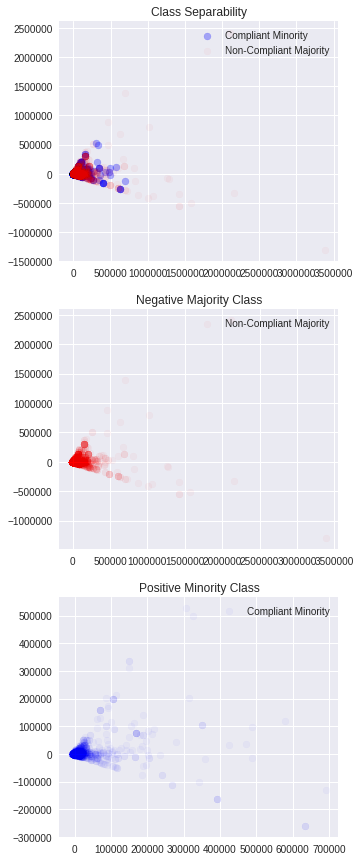

In [26]:
# Here, we create three separate plots. The first plot shows both of the classes. Since there are lots of overlapping points, however, we also plot the points
# separately with low alpha values to give an idea of the density of each of the classes.


f, (ax1, ax2, ax3) = plt.subplots(3,1, figsize = (5, 15))
ax1.scatter(X_pca[y==1,0],X_pca[y==1,1], c = 'b', alpha = 0.3, marker='o', label = 'Compliant Minority')
ax1.scatter(X_pca[y==0, 0], X_pca[y==0, 1], c = 'r', alpha = 0.03, marker='o', label='Non-Compliant Majority')
ax1.set_title('Class Separability')  
ax1.legend(loc='upper right')          
ax2.scatter(X_pca[y==0,0],X_pca[y==0,1], c =  'r', alpha = 0.03, marker='o', label = 'Non-Compliant Majority')
ax2.set_title('Negative Majority Class')
ax2.legend(loc = 'upper right')
ax3.scatter(X_pca[y==1,0],X_pca[y==1,1], c= 'b', alpha = 0.03, marker='o', label = 'Compliant Minority')
ax3.legend(loc='upper right')
ax3.set_title('Positive Minority Class')

## Model Training and Hyperparameter Tuning (Discussion of Tuning Strategy)

The tuning strategy used is dictated by practicality. While in principal one should use gridsearch or randomised search to select parameters due to the fact that they are to some extent dependent on one another, this dramatically increases search time. Since we have a lot of variables, each model takes a long time to construct and so this is a particularly important issue. As a result, we tune the most important parameters first.

In [27]:
# Start off with a relatively high learning rate and a high number of estimators. Use early stopping to determine the optimal number of estimators
# for this learning rate. The reason for starting off with a high learning rate is computing power: generally speaking, a lower learning rate means
# more estimators are needed and the training time is correspondingly longer. This is particularly true given the cross validation process for hyperparameter
# tuning: since multiple models need to be learned, it is better to manage the trade off between learning rate and number of trees by setting a relatively
# high learning rate.

from xgboost import XGBClassifier
import xgboost as xgb
import math

clf =  XGBClassifier(learning_rate = 0.1, n_estimators = 5000, max_depth=5,
 min_child_weight=1/(math.sqrt(y_train.sum()/len(y_train))), gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', scale_pos_weight=1, seed = 2)

xgb_param = clf.get_xgb_params()
xgtrain = xgb.DMatrix(X_train, y_train)
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round = clf.get_params()['n_estimators'], folds = tscv2,
metrics = 'auc', early_stopping_rounds=50, verbose_eval = True, seed = 2)

# Set number of estimators to the optimal value found for this chosen learning rate.
clf.set_params(n_estimators=cvresult.shape[0])
# View new parameters
clf.get_params

[0]	train-auc:0.81231+0.00153297	test-auc:0.805548+0.0020077
[1]	train-auc:0.816356+0.00123588	test-auc:0.809955+0.00385067
[2]	train-auc:0.817355+0.00179895	test-auc:0.811654+0.00398348
[3]	train-auc:0.817879+0.0015647	test-auc:0.8121+0.00417967
[4]	train-auc:0.82067+0.000356061	test-auc:0.813968+0.00414132
[5]	train-auc:0.822221+0.00137285	test-auc:0.815186+0.00342016
[6]	train-auc:0.82419+0.00189917	test-auc:0.815849+0.0038079
[7]	train-auc:0.824804+0.00225619	test-auc:0.816424+0.00300426
[8]	train-auc:0.825723+0.00204037	test-auc:0.816846+0.00319046
[9]	train-auc:0.826888+0.00196558	test-auc:0.8176+0.00315835
[10]	train-auc:0.827876+0.00111776	test-auc:0.818702+0.00409815
[11]	train-auc:0.828334+0.00112498	test-auc:0.818679+0.0041264
[12]	train-auc:0.829342+0.00107153	test-auc:0.819331+0.00393435
[13]	train-auc:0.830219+0.000986956	test-auc:0.819975+0.00390791
[14]	train-auc:0.830617+0.00157911	test-auc:0.820265+0.00402122
[15]	train-auc:0.830654+0.00131756	test-auc:0.820271+0.0037

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=3.778326517884773, missing=None,
       n_estimators=233, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8)>

In [28]:
# Get the auc score for the first instance so we can see how much hyperparameter tuning helps later on.
clf.fit(X_train, y_train)
roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

0.7961729436272744

## Visualisation and Discussion of Feature Importances

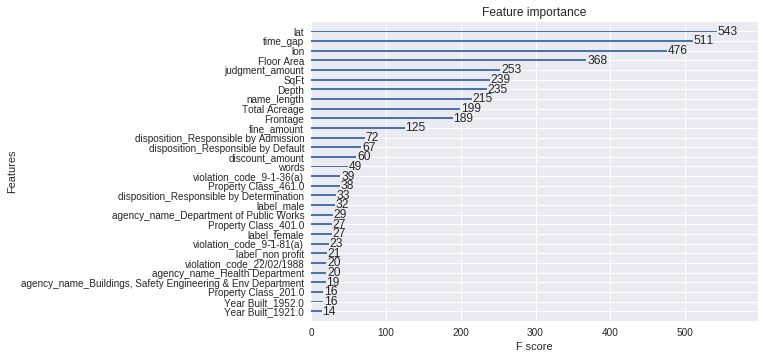

In [29]:
# One of the key advantages of using the gradient boosting classifier is that it isn't fully a black box model: we can see which features are most important to
# separating the classes. Since the are so many dummies for this problem, we simply look at the most important features.

# This is useful in that it also suggests certain features over which the state has control can be manipulated so as to increase the likelihood of compliance. Although we don't
# have signs for the variables, these are time_gap, judgement_amount, fine_amount, judgement amount. Can target these variables at types that are likely to be a problem potentially.

from xgboost import plot_importance
plot_importance(clf, max_num_features = 30)

The model used (gradient boosting classifier) is not fully black box: it allows feature importances to be seen, Feature importances indicate how often a feature was used to create tree splits. This is an indicator for how important a variable is for determining a class. While such indicators are not quite as powerful as information obtained from a rigorously designed inferential model, they can still be used to infer reasonable changes to policy. For example, one of the features engineered from the data is the time gap between the the hearing data and the ticket issue date. This feature is one of the most important. Other features such as judgement amount, fine amount and discount amount were also somewhat important. Since each of these features is under the control of the Detroit government, the model can inform them about how they might change policy to increase compliance. For example, since the time gap is the most important, they might focus on ensuring a shorter time gap between the ticket issued date and hearing date for the largest fines to provide greater incentives to pay. The model presented here suggests this would be a fruitful strategy.

## Aside - Should we generate Polynomial Features?

The XGBoost algorithm approximates nonlinear transformations and interactions fairly well. As a result, only very strong nonlinear combinations of features will improve performance. Somewhat arbitrarily, quadratic terms (including interactions) for the 10 most important features in the feature importances graph were constructed and added to the original dataframe. However, the inclusion of such variables did not help and so the strategy was aborted. The inclusion of non-linear features did not improve apparent class separability in the PCA visual plots either.

In [30]:
# See how many features were not used at all as discriminators compared to the number of features. Here we see most of the features were not used.
print(np.count_nonzero(clf.feature_importances_))
len(clf.feature_importances_)

126


403

In [0]:
# Delete features with 0 importance to save training time for hyperparameter tuning as tree based models use a greedy approach.
# The more features there are, the more splits there are to try, so eliminating useless features (zero valued), of which there are many,
# is a worthwhile task.

from sklearn.feature_selection import SelectFromModel

selection = SelectFromModel(clf, threshold=0.0001, prefit=True)
select_X_train = selection.transform(X_train)
select_X_test = selection.transform(X_test)

In [32]:
# As max_depth and min_child_weight are the parameters that will have the largest impact on model outcome, we will tune these first.
# Since the impact of different hyperparameters are not independent from one another, this is a theoretical shortcut used to save 
# on computation time. Technically by doing this, we are assuming that hyperparameters tuned in different grid searches are independent
# from one another. Though this is not technically true, it is likely to be a good enough first approximation, particularly given the computing time saved.

param_test1 = {
 'max_depth':range(3,8,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = clf, 
 param_grid = param_test1, scoring='roc_auc',n_jobs=1,iid=False, cv=tscv2, verbose = 2)
gsearch1.fit(select_X_train,y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] max_depth=3, min_child_weight=1 .................................
[CV] .................. max_depth=3, min_child_weight=1, total=   6.5s
[CV] max_depth=3, min_child_weight=1 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s remaining:    0.0s


[CV] .................. max_depth=3, min_child_weight=1, total=  13.4s
[CV] max_depth=3, min_child_weight=1 .................................
[CV] .................. max_depth=3, min_child_weight=1, total=  20.2s
[CV] max_depth=3, min_child_weight=1 .................................
[CV] .................. max_depth=3, min_child_weight=1, total=  27.1s
[CV] max_depth=3, min_child_weight=1 .................................
[CV] .................. max_depth=3, min_child_weight=1, total=  34.3s
[CV] max_depth=3, min_child_weight=3 .................................
[CV] .................. max_depth=3, min_child_weight=3, total=   6.5s
[CV] max_depth=3, min_child_weight=3 .................................
[CV] .................. max_depth=3, min_child_weight=3, total=  13.1s
[CV] max_depth=3, min_child_weight=3 .................................
[CV] .................. max_depth=3, min_child_weight=3, total=  20.3s
[CV] max_depth=3, min_child_weight=3 .................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 24.7min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.80422, std: 0.03742, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.80280, std: 0.03779, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.80215, std: 0.03642, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.79725, std: 0.03885, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.79734, std: 0.03995, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.79586, std: 0.03967, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.79125, std: 0.04035, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.78927, std: 0.03947, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.79041, std: 0.04062, params: {'max_depth': 7, 'min_child_weight': 5}],
 {'max_depth': 3, 'min_child_weight': 1},
 0.8042203934956544)

In [33]:
# Update classifier parameters to reflect previous grid search
clf.set_params(max_depth = 3, min_child_weight = 1)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=233,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8)

In [34]:
# Since we took intervals of two, now search for one above and one below each of the previous best values and include the best value for comparison to see if we can improve any further.
# While in principal we could have tested these values before, which would be more theoretically correct due to the independence problem, this is quicker from a computing power perspective.
param_test2 = {
 'max_depth':[2,3,4],
 'min_child_weight':[2]
}

gsearch2 = GridSearchCV(estimator = clf, 
 param_grid = param_test2, scoring='roc_auc',n_jobs=1,iid=False, cv=tscv2, verbose = 2)
gsearch2.fit(select_X_train,y_train)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] max_depth=2, min_child_weight=2 .................................
[CV] .................. max_depth=2, min_child_weight=2, total=   4.7s
[CV] max_depth=2, min_child_weight=2 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s


[CV] .................. max_depth=2, min_child_weight=2, total=   9.3s
[CV] max_depth=2, min_child_weight=2 .................................
[CV] .................. max_depth=2, min_child_weight=2, total=  14.2s
[CV] max_depth=2, min_child_weight=2 .................................
[CV] .................. max_depth=2, min_child_weight=2, total=  19.2s
[CV] max_depth=2, min_child_weight=2 .................................
[CV] .................. max_depth=2, min_child_weight=2, total=  24.2s
[CV] max_depth=3, min_child_weight=2 .................................
[CV] .................. max_depth=3, min_child_weight=2, total=   6.4s
[CV] max_depth=3, min_child_weight=2 .................................
[CV] .................. max_depth=3, min_child_weight=2, total=  13.2s
[CV] max_depth=3, min_child_weight=2 .................................
[CV] .................. max_depth=3, min_child_weight=2, total=  20.1s
[CV] max_depth=3, min_child_weight=2 .................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  5.1min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.80475, std: 0.03497, params: {'max_depth': 2, 'min_child_weight': 2},
  mean: 0.80294, std: 0.03746, params: {'max_depth': 3, 'min_child_weight': 2},
  mean: 0.80182, std: 0.03673, params: {'max_depth': 4, 'min_child_weight': 2}],
 {'max_depth': 2, 'min_child_weight': 2},
 0.8047465262162046)

In [35]:
# Though it may be tempting to select paramets based on the roc_auc_score on the test set, we shouldn't use this because of data leakage. We can't tune based on an unseen test set.
clf.set_params(max_depth = 2, min_child_weight = 2)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=2, missing=None, n_estimators=233,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8)

In [37]:
# Recalibrate number of boosting rounds for updated parameters
clf.set_params(n_estimators = 5000)

xgb_param = clf.get_xgb_params()
xgtrain = xgb.DMatrix(select_X_train, y_train)
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round = clf.get_params()['n_estimators'], folds = tscv2,
metrics = 'auc', early_stopping_rounds=50, verbose_eval = True, seed = 2)

clf.set_params(n_estimators=cvresult.shape[0])
clf.get_params

[0]	train-auc:0.750665+0.00166588	test-auc:0.750453+0.00313681
[1]	train-auc:0.758816+0.0108805	test-auc:0.757957+0.0136175
[2]	train-auc:0.761535+0.0147161	test-auc:0.761097+0.0179851
[3]	train-auc:0.761933+0.0152774	test-auc:0.761565+0.0186396
[4]	train-auc:0.761664+0.0154853	test-auc:0.761319+0.0187599
[5]	train-auc:0.77019+0.0148627	test-auc:0.769233+0.0142008
[6]	train-auc:0.780656+0.000853654	test-auc:0.779212+0.00649202
[7]	train-auc:0.780656+0.000853654	test-auc:0.779212+0.00649202
[8]	train-auc:0.781672+0.00183974	test-auc:0.780503+0.00676719
[9]	train-auc:0.78674+0.00853587	test-auc:0.786334+0.00466964
[10]	train-auc:0.789559+0.00781255	test-auc:0.789366+0.00373389
[11]	train-auc:0.789559+0.00781255	test-auc:0.789366+0.00373389
[12]	train-auc:0.789559+0.00781255	test-auc:0.789366+0.00373389
[13]	train-auc:0.795228+0.00840486	test-auc:0.794338+0.00433935
[14]	train-auc:0.802308+0.00260771	test-auc:0.800573+0.00320263
[15]	train-auc:0.802461+0.00259891	test-auc:0.800818+0.00354

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=2, missing=None, n_estimators=345,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8)>

In [38]:
# Since the cross validation strategy is already biased towards less complexity, and gamma (regularisation parameter) isn't often tuned, leave it. Here we tune subsample and colsample by tree

param_test3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]}

gsearch3 = GridSearchCV(estimator = clf, 
 param_grid = param_test3, scoring='roc_auc',n_jobs=1,iid=False, cv=tscv2, verbose = 2)
gsearch3.fit(select_X_train,y_train)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch1.best_score_

    

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] .............. colsample_bytree=0.6, subsample=0.6, total=   6.2s
[CV] colsample_bytree=0.6, subsample=0.6 .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s remaining:    0.0s


[CV] .............. colsample_bytree=0.6, subsample=0.6, total=  12.5s
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] .............. colsample_bytree=0.6, subsample=0.6, total=  18.8s
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] .............. colsample_bytree=0.6, subsample=0.6, total=  25.2s
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] .............. colsample_bytree=0.6, subsample=0.6, total=  31.9s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV] .............. colsample_bytree=0.6, subsample=0.7, total=   5.7s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV] .............. colsample_bytree=0.6, subsample=0.7, total=  11.4s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV] .............. colsample_bytree=0.6, subsample=0.7, total=  17.6s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 28.0min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.80213, std: 0.03478, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.80238, std: 0.03341, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.80179, std: 0.03370, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.80214, std: 0.03460, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.80065, std: 0.03439, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.80239, std: 0.03449, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.80181, std: 0.03518, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.80205, std: 0.03475, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.80160, std: 0.03434, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.80135, std: 0.03458, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.80199, std: 0.03466, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.80226, std: 0.03410, params: {'colsample_bytree': 0.8, 'subsample'

In [39]:
clf.set_params(colsample_bytree = 0.7 , subsample = 0.7)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=2, missing=None, n_estimators=345,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7)

In [40]:
# Recalibrate number of boosting rounds for updated parameters. Set lower learning rate.
clf.set_params(n_estimators = 10000, learning_rate = 0.01)

xgb_param = clf.get_xgb_params()
xgtrain = xgb.DMatrix(select_X_train, y_train)
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round = clf.get_params()['n_estimators'], folds = tscv2,
metrics = 'auc', early_stopping_rounds=50, verbose_eval = True, seed = 2)

clf.set_params(n_estimators=cvresult.shape[0])
clf.get_params

[0]	train-auc:0.750666+0.00166549	test-auc:0.750455+0.00313779
[1]	train-auc:0.75403+0.00417669	test-auc:0.754055+0.0082949
[2]	train-auc:0.783821+0.00452816	test-auc:0.782377+0.0102809
[3]	train-auc:0.783622+0.00426171	test-auc:0.782156+0.0100241
[4]	train-auc:0.783634+0.00531723	test-auc:0.782124+0.0108038
[5]	train-auc:0.78506+0.00349103	test-auc:0.782972+0.00850255
[6]	train-auc:0.785191+0.00333114	test-auc:0.783013+0.00849455
[7]	train-auc:0.7857+0.00321856	test-auc:0.78367+0.00699473
[8]	train-auc:0.788924+0.00733836	test-auc:0.787635+0.0129895
[9]	train-auc:0.795597+0.0107592	test-auc:0.79516+0.00996822
[10]	train-auc:0.797025+0.0123424	test-auc:0.796174+0.0104386
[11]	train-auc:0.797025+0.0123428	test-auc:0.796174+0.010439
[12]	train-auc:0.797025+0.0123424	test-auc:0.796174+0.0104386
[13]	train-auc:0.797027+0.0123808	test-auc:0.796145+0.0104139
[14]	train-auc:0.797027+0.0123808	test-auc:0.796145+0.0104139
[15]	train-auc:0.797059+0.0123848	test-auc:0.796174+0.0104386
[16]	train-

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=2, min_child_weight=2, missing=None, n_estimators=2778,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=2, silent=True,
       subsample=0.7)>

## Final Score - Did Hyperparameter Tuning Work?

In [41]:
clf.fit(X_train, y_train)
roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

0.7954200173393551

Hyperparameter tuning did not improve performance. Somewhat surprisingly, performance on the test set actually fell. Though it is not uncommon for tuning gradient boosting algorithms to have little effect on performance, a slight decrease in performance on the test set is surprising. However, as seen earlier in the PCA visualisation, it is extraordinarily difficult to separate the classes with either linear or non linear decision boundaries and so maximal performance is limited. Another factor may be that the forward chaining method described earlier biases the model towards underfitting because of the necessary small sample sizes in the some of the training folds.

Yet another factor that may explain the lack of a performance improvement is interdependence between the tuned parameters (the parameters were tuned separately to save computing time because the number of features meant that a legitimate gridsearch or randomised search would take too long.)

## Visualisation of Results and Selecting the Decision Threshold

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix, without normalization
[[35429    14]
 [ 2219   104]]
Normalized confusion matrix
[[1.00e+00 3.95e-04]
 [9.55e-01 4.48e-02]]


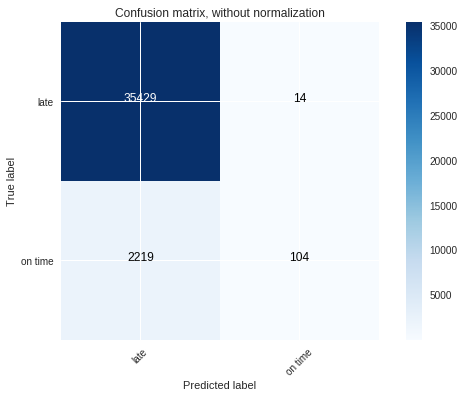

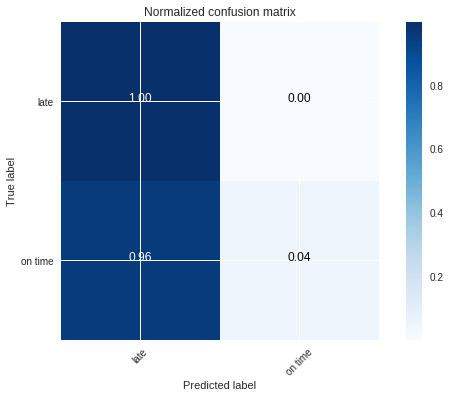

In [42]:
# First, lets plot both normalised and non-normalised confusion matrices showing the results.


import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Get predicted values.
predictions = clf.predict(X_test)

# Get class names
class_names = ['late', 'on time']
    
    
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predictions)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

As we can see, the model is highly biased towards predicting the majority class (non-compliance) which leads to a high proportion of false positives. In practical terms, this means the state would waste a lot of time and resources chasing people who will comply with fines anyway. This is costly because these resources could be used chasing people who actually are non compliers. It is not surprising that the model has predicted in this way given the imbalance of the dataset towards the negative class and the clustering of classes (inseparability in feature space). However, to get a more favourable outcomes we can simply shift the decision boundary.

Reducing the proportion of false positives is easily done by shifting the decision boundary. However, there is a trade off: reducing false positives by making it more likely to predict negatives will increase false negatives. This may be seen by the Detroit state as a worthwhile trade off. if resources are limited, failing to chase some violators is not costly because not all violators can be caught anyway. This trade off can be roughly seen in the precision recall curve (though it must be noted that this is not exactly the same as the trade off between false positives and false negatives)

(0.0, 1.0)

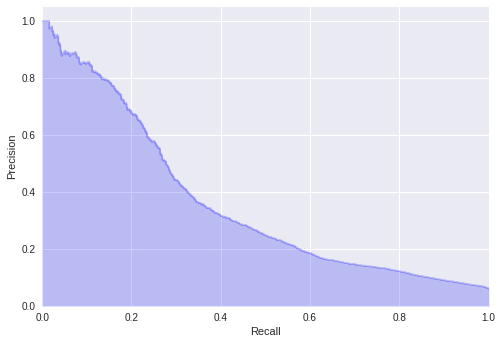

In [43]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

precision, recall, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test)[:,1])

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

If we want a high recall (not many false positives) we have to sacrifice a lot of precision. Again this is not surprising given the difficulty of separating the classes implied by the PCA diagram. This may not be a problem if we go by the highest probabilities in each class.

Confusion matrix, without normalization
[[23424 12019]
 [  528  1795]]
Normalized confusion matrix
[[0.66 0.34]
 [0.23 0.77]]


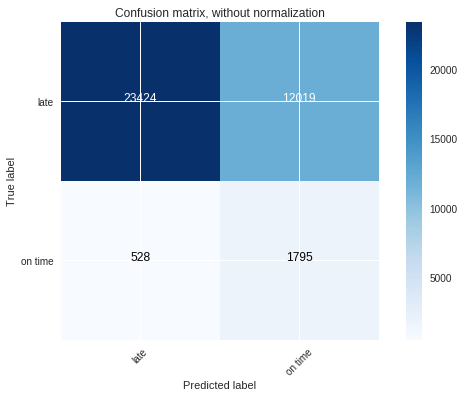

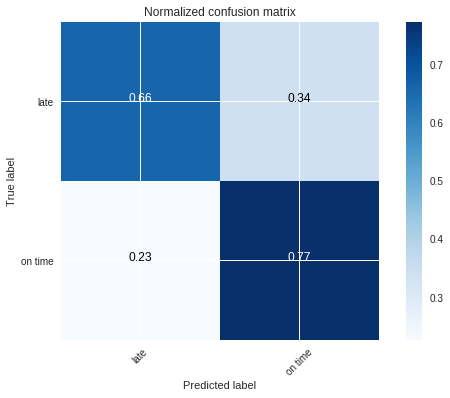

In [44]:
# Lower decision threshold to 0.044 from 0.5. This means entities are far less likely to be predicted to be late
# and more likely to be predicted to be on time, thus reducing the incidence of false negatives (which are costly because wrongly predicting non-compliance
# means resources are wasted pursuing someone who will pay anyway). This comes at the cost of increasing the incidence of false positives (wrongly predicting
# that non compliers will pay on time, but this is unlikely to be as costly). Here the threshold has been picked to roughly equalise accuracy for both classes, but in practice the boundary
# could be shifted further to reduce false negatives further still. This boundary, however, has the intuitive interpretation for model performance - we can get around 70% accuracy on both classes in our
# model, which though not perfect, is a decent performance given the difficulty in separating the classes for this problem (see PCA visual)

predictions = [1 if i>=0.044 else 0 for i in clf.predict_proba(X_test)[:,1]]

# Get class names
class_names = ['late', 'on time']
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predictions)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Changing the decision threshold gives much more balances predictions, as we can see. In fact, if resources are limited a 23% false negative rate is fairly good.

## Why difficulty Separating the Classes Might Not be a Huge Problem in Practice

Although the classes have proved difficult to separate, this might not be overly problematic in practice.

The model contains probability estimates such that within each class, probabilities of compliance and non compliance can be obtained. The Detroit government could rationally use these estimates by pursuing violators with the highest predicted probabiities of not paying on time first. Below we can see that for the violators with the highest 1029 predicted probabilities of non compliance, only 29 were actually compliant. So if the state only had enough resources to pursue the first 1029 highest probability violators,  there would be far less resource wastage than implied by the confusion matrix displayed above. The false negative rate (i.e.pursuing someone who will compy anyway) is a mere 2.8% in this case.

In [45]:
# Probability of non-compliance for cases where they were not compliant.
x4 =  clf.predict_proba(X_test)[:,0][y_test==0]
# Highest predicted probabilities of non compliance for non compliant cases.
(x4[np.argsort(x4)[-1000:]])

array([0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99,
       0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99,
       0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99,
       0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99,
       0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99,
       0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99,
       0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99,
       0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99,
       0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99,
       0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99,
       0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99,
       0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99,
       0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99,
       0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.

In [46]:
# Probability of non-compliance for cases where they were actually compliant.
x2 =  clf.predict_proba(X_test)[:,0][y_test==1]
# Highest predicted probabilities of non compliance for compliant cases.
(x2[np.argsort(x2)[-1000:]])

array([0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93,
       0.93, 0.93, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94,
       0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94,
       0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94,
       0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94,
       0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94,
       0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94,
       0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94,
       0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94,
       0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94,
       0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94,
       0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94,
       0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94,
       0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.

## Conclusion

Using only information available to the Detroit government at the time a fine is issued, this project predicts the probability of a blight violator complying with a fine. The model is useful in a number of ways. It could be used by the Detroit government to prevent them from wasting resources pursuing people who will comply anyway (false positives). This could result in significant monetary savings as less resources would be needed to capture true positives with a higher hit rate. It could also increase revenues as false negatives would now be more likely to be pursued, caught and pay their fines. Over a long time, improved performance might also give violators a greater incentive to pay if they know they are more likely to be chased. 

Since the model used (gradient boosting classifier) is not fully black box in the sense that it allows feature importances to be seen, it could be used to change policy. Feature importances suggest that one of the features we engineered from the data - (the time gap between the the hearing data and the ticket issue date) is one of the most important for the model's predictive performance. Other features such as judgement amount, fine amount and discount amount were also somewhat important. Since each of these features is under the control of the Detroit government, the model can inform them about how they might change policy to increase compliance. Since the time gap is the most important, they might focus on ensuring a shorter time gap between the ticket issued date and hearing date for the largest fines to provide greater incentives to pay. The model presented here suggests this would be a fruitful strategy.

A number of strategies were attempted to improve performance in the blight ticket compliance prediciton task. These strategies included, but were not limited to:

1) Building an entity classifier to convert violator names into their associated types. Despite using a complex concatenated LSTM network model that performed well on the test set, this did not improve performance.

2) Using imbalanced learning models from imblearn. This did not help, most likely due to the very strong clustering/overlapping of the classes, as shown in the PCA visualisation.

3) Hyperparameter Tuning

3) Ensembles of models/Voting Classifier

None of these approaches were able to improve performance markedly. This is perhaps not surprising given the PCA visualisation seen earlier: using the available data, the classes are extremely hard to separate with either linear or non linear classification boundaries. That is, there was not a great deal of difference between the feature values of members of the positive class and members of the negative class. Some feature engineering was attempted as explained above, but most of these methods were not able to increase separability by a large amount and so the class overlap problem remained.. The types of feature engineering used were largely guided by intuition: it was thought that the entity types associated with violator names would be a strong predictor of compliance. While this may be the case in reality, unfortunately the entity classifier did not generalise well to the blight data for various reasons outlined in the generating features section. Instead, the length of the violator names and the number of words in each name was used as a much simpler rough correlate of such information. These features did show some importance. 

Another feature that was engineered was the time gap between the hearing date and the ticket issued date. This feature had one of the highest feature importances and so was a successfully engineered feature. Intuition guided the design of this feature: it was thought that individuals facing a hearing date in the distant future would have far less incentive to pay their fine than individuals with a nearby hearing date. Given the importance of this feature, the Detroit government could use it to incentivise violators by placing hearing dates nearer to ticket issued dates for violators with characteristics that indicate potential non compliance. Although feature importances from an XGBoost model cannot be interpreted with the same degree of confidence as parameters from a rigorous inferential statistics model, they do give us some insight into how we might improve compliance because it is likely that the time gap has a high feature importance for the reason we would intuitively expect: incentives. Some other featues with relatively high feature importances could also be manipulated by the detroit government in a similar manner to provide incentives. The model is useful in that it shows which features should be manipulated with highest priority.

Engineering non linear transforms of certain variables that feature importances had indicated would be useful was also attempted. This did not improve performance, which is not surprising given that xgboost approximates such nonlinearities anyway. Only when non linearities are very very strong predictors will they increase performance markedly in an xgboost model for this reason.

One of the main lesson of this project is that visualisations give a guide as to the performance one should expect. If a pca plot shows little separability even though the first 2/3 components capture most of the variance, then either features need to be engineered to improve separability or expectations for performance shoul be tempered. 


